# Kanapy
## Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
Copyright &copy; by the author, August 2025

## 1. Prepare system settings

In [1]:
import kanapy as knpy
import numpy as np
print(f'Kanapy version {knpy.__version__}')

Kanapy version 6.5.2


## 2. Analyse EBSD map with MTEX module and determine statistical microstructure descriptors
Microstructure geometry parameters are calculated based on the given EBSD map.
<img alt="EBSD map 316L" src="Figures/ebsd_316L_experiment.png">
<img src="Figures/IPFkey.png" alt="IPF key" style="width:200px">


Imported EBSD map with 1 phases.
Initial number of bad pixels: 3040
After 3041 loops: number of bad pixels: 0
Identifying regions of homogeneous misorientations and assigning them to grains.
Phase #0 (Iron fcc): Identified Grains: 351
Building microstructure graph.
Starting to simplify microstructure graph.


INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Fallback to method "raw" due to exception No elliptical fit was found..
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "

After merging of similar regions, 245 grains left.
After elimination of small grains, 206 grains left.

--------------------------------------------------------
Statistical microstructure parameters in pixel map 
--------------------------------------------------------
16.2811617768674 30.368674610960504
6.40711778022994 12.228384230452857
18.146279957583054 32.40785267197926


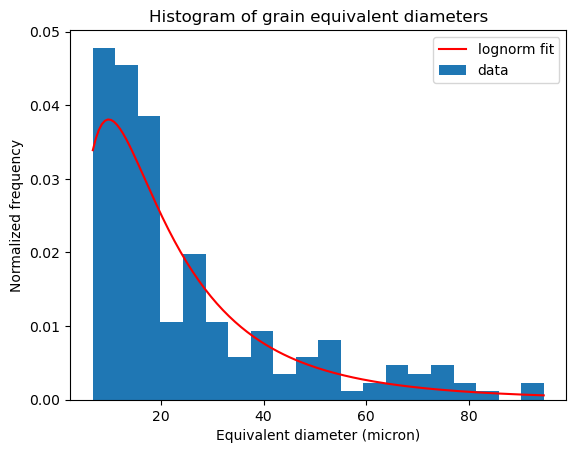

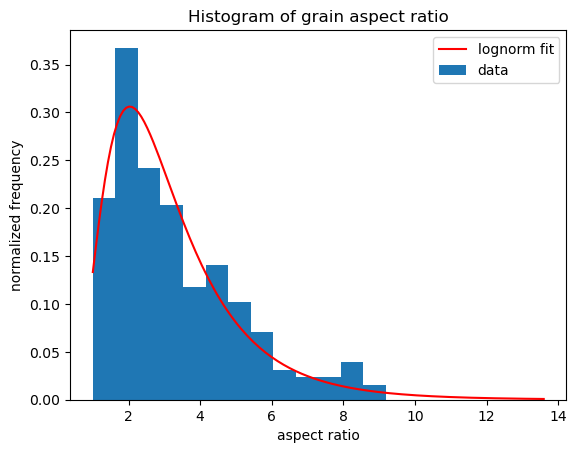

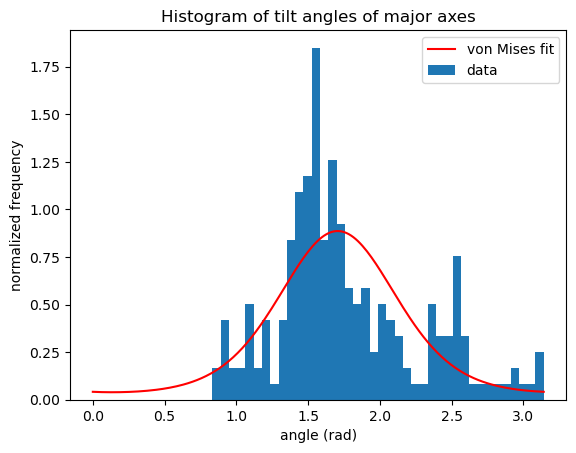

Analyzed microstructure of phase #0 (Iron fcc) with 206 grains.
Median values: equiv. diameter: 18.146 micron, aspect ratio: 2.754, tilt angle: 15.485°
Std. dev: equivalent diameter: 0.787 micron, aspect ratio: 0.551, tilt angle: 58.563°


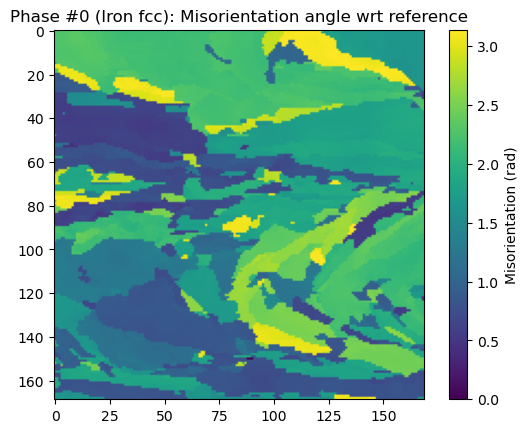

/opt/miniconda3/envs/knpy/lib/python3.10/site-packages/kanapy/texture.py:1309: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


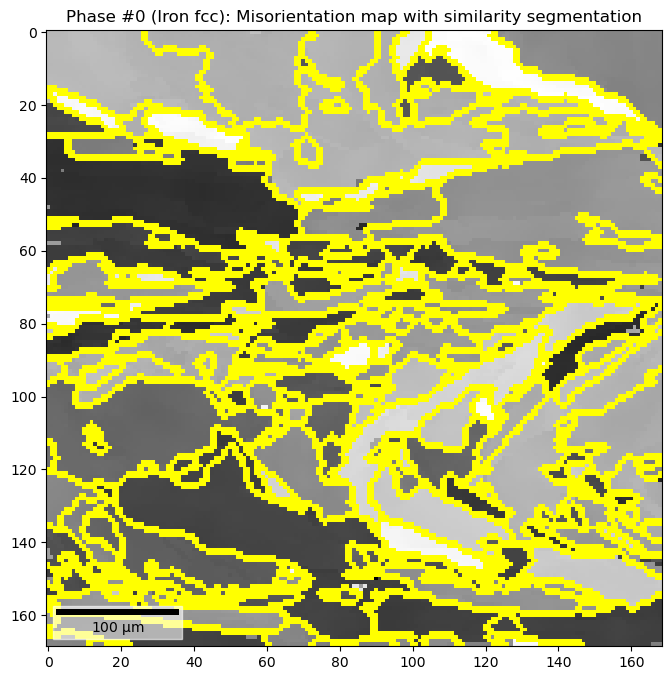

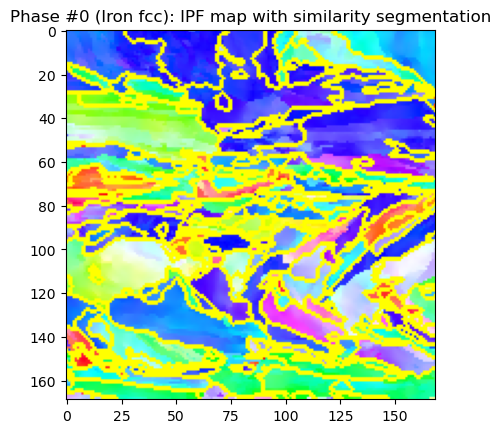

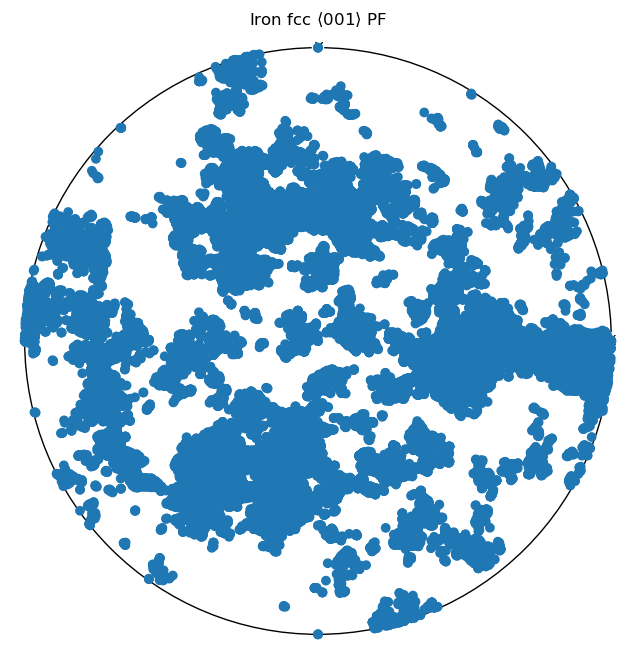


*** Statistical information on microstructure ***
Found 1 phases in EBSD map.

----------------------------
=== Phase 1:  Iron fcc ===
---------------------------
Volume fraction: 1.0
==== Grain size (equivalent grain diameter) ====
-- Moments --
median: 18.146 micron, std. deviation: 0.787 micron
-- Fit parameters --
scale: 18.146, location: 0.0, std. deviation: 0.787
==== Aspect ratio ====
-- Moments --
median: 2.754, std. deviation: 0.551
-- Fit parameters --
scale: 2.754, location: 0.0, std. deviation: 0.551
==== Tilt angle ====
-- Moments --
median: 15.485°, std. deviation: 58.563°
-- Fit parameters --
mean value: 0.27, std. deviation: 1.558


In [2]:
fname = '../EBSD_analysis/ebsd_316L_500x500.ang'  # name of ang file to be imported

# read EBSD map and evaluate statistics of microstructural features
ebsd = knpy.EBSDmap(fname)
ms_data = ebsd.ms_data[0]  # analyse only data for majority phase with order parameter "0"
matname = ms_data['name'].lower().replace(' ', '_')  # material name = MTEX Phase name (lower case and w/o blanks)
gs_param = ms_data['gs_param']  # parameters for lognorm distr of grain size: [std dev., location, scale]
ar_param = ms_data['ar_param']  # parameters for lognorm distr. of aspect ratios [std dev., location, scale]
om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles [std dev., mean]
print('\n*** Statistical information on microstructure ***')
print(f'Found {len(ebsd.ms_data)} phases in EBSD map.')
for i, ms in enumerate(ebsd.ms_data):
    print('\n----------------------------')
    print(f'=== Phase {i+1}: ', ms['name'], '===')
    print('---------------------------')
    print(f'Volume fraction: {ms["vf"]}')
    print('==== Grain size (equivalent grain diameter) ====')
    print('-- Moments --')
    print(f'median: {ms["gs_moments"][0].round(3)} micron, ' +
      f'std. deviation: {ms["gs_moments"][1].round(3)} micron')
    print('-- Fit parameters --')
    print(f'scale: {ms["gs_param"][2].round(3)}, ' +
      f'location: {ms["gs_param"][1].round(3)}, ' +
      f'std. deviation: {ms["gs_param"][0].round(3)}')
    print('==== Aspect ratio ====')
    print('-- Moments --')
    print(f'median: {ms["ar_moments"][0].round(3)}, ' +
      f'std. deviation: {ms["ar_moments"][1].round(3)}')
    print('-- Fit parameters --')
    print(f'scale: {ms["ar_param"][2].round(3)}, ' +
      f'location: {ms["ar_param"][1].round(3)}, ' +
      f'std. deviation: {ms["ar_param"][0].round(3)}')
    print('==== Tilt angle ====')
    print('-- Moments --')
    print(f'median: {(ms["om_moments"][0]*180/np.pi).round(3)}°, ' +
      f'std. deviation: {(ms["om_moments"][1]*180/np.pi).round(3)}°')
    print('-- Fit parameters --')
    print(f'mean value: {ms["om_param"][1].round(3)}, ' +
          f'std. deviation: {ms["om_param"][0].round(3)}')


## 3. Generate representative volume element (RVE)
In this part, a representative volume element (RVE) is generated based on the experimental input data.

**Step 1:** To generate the statistics dictionary required by Kanapy, the `set_stats()` method is called with arguments defineing the statistical descriptors for grain size, aspect ratio and omega parameters as determined from the EBSD map. Other parameters need to be set manually. They include lower and upper cutoff values for distributions of equivalent diameters (`deq_min`, `deq_max`), aspect ratio (`asp_min`, `asp_max`) and tilt angle (`omega_min`, `omega_max`). Furthermore, the number of voxels (`voxels`), side length of RVE (`size`), its periodicity (`periodicity`), and volume fraction, phase name and number (`VF`, `phasename`, and `phasenum`) need to be specified.


In [3]:
# create dictionary with statistical information obtained from EBSD map
Nv = 30  # number of voxels per side
size = 50  # side length of generated RVE in micron
periodic = True  # create periodic RVE
ms_stats = knpy.set_stats(gs_param, ar_param, om_param,
                          deq_min=8.0, deq_max=19.0, asp_min=0.95, asp_max=3.5,
                          omega_min=0.0, omega_max=np.pi, voxels=Nv, size=size,
                          periodicity=periodic,
                          VF=1.0, phasename=matname, phasenum=0)
print('*** Statistical microstructure descriptors ***')
ms_stats

*** Statistical microstructure descriptors ***


{'Grain type': 'Elongated',
 'Equivalent diameter': {'sig': np.float64(0.7871155660200708),
  'loc': np.float64(0.0),
  'scale': np.float64(18.146279957583054),
  'cutoff_min': 8.0,
  'cutoff_max': 19.0},
 'RVE': {'sideX': 50, 'sideY': 50, 'sideZ': 50, 'Nx': 30, 'Ny': 30, 'Nz': 30},
 'Simulation': {'periodicity': True, 'output_units': 'um'},
 'Phase': {'Name': 'iron_fcc', 'Number': 0, 'Volume fraction': 1.0},
 'Aspect ratio': {'sig': np.float64(0.5505947966591895),
  'loc': np.float64(0.0),
  'scale': np.float64(2.7541535336982212),
  'cutoff_min': 0.95,
  'cutoff_max': 3.5},
 'Tilt angle': {'kappa': np.float64(1.5576952542215134),
  'loc': np.float64(0.27026914795156554),
  'cutoff_min': 0.0,
  'cutoff_max': 3.141592653589793}}

**Step 2:** Using the `Microstructure` class of Kanapy, a microstructure object is generated, by passing the microstructure descriptors 'ms_stats' obtained from the EBSD analysis as input data to this class. The Python dictionary 'ms_stats' also contains the geometrical definition of the RVE box. After this, the method `plot_stats_init()` plots the statistical distributions that will be used for the particle simulation. The experimental histogram of grain size and aspect ratio distributions are passed as argument 'gs_data' and 'ar_data'. In this case, the size distribution of the grains in the microstructure (orange bars) is fitted by a log-normal distribution (blue line). Finally, the method `init_RVE()` creates the particle set that fulfills the required size distribution within the given lower (dashed vertical line) and upper (solid vertical line) bound.

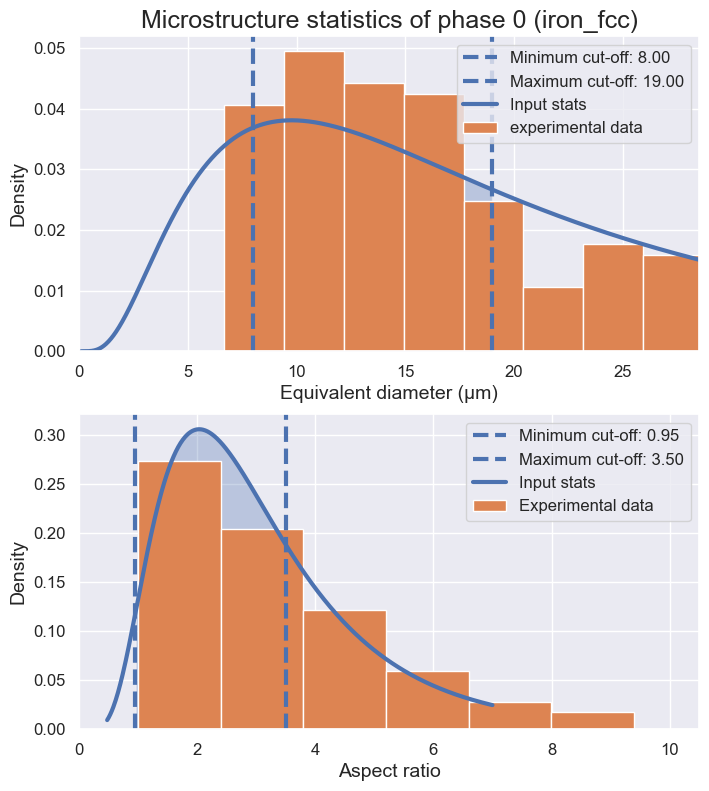

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 90
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (50, 50, 50) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.6667 1.6667 1.6667](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: iron_fcc (100.0%)




In [4]:
# Create box with ellipsoids that represent future grains
ms = knpy.Microstructure(descriptor=ms_stats, name=matname+'_RVE')
ms.plot_stats_init(gs_data=ms_data['gs_data'], ar_data=ms_data['ar_data'])
ms.init_RVE()

**Step 3:** Perform the particle simulation by invoking the method `pack()`. To accomplish this, the particles generated in the last step are initally downscaled in size by a factor of 100 such that they can move freely through the simulation box but still fulfill the same charactistics of the size distribution with larger and smaller particles in the desired quantities. To avoid overlap of particles, collsions are considered. In this way, the particles form a realistic distribution within the space of the simulation box, as can be verified in the plot by `plot_ellipsoids()`.  
**Note:** As the particle simulations can be quite time consuming, particle configurations can be saved by passing the optional argument "save_files=True" to the `pack()`method. Then, the last particle file can be imported with the `import_particles()` method. The particles are saved a "dump" files that can also be imported and visualized with the Software package [Ovito](https://ovito.org), see also the section "Visualize the packing simulation" in the [Kanapy documentation](https://icams.github.io/Kanapy/builds/html/usage.html#visualize-the-packing-simulation).

Starting particle simulation
    Creating particles from distribution statistics
    Total volume of generated ellipsoids: 121396.44646895402
    Particle packing by growth simulation
Volume of simulation box: 125000
Volume of unscaled particles: 121396.44646895402
Initial volume of scaled ellipsoids: 121.39644646895411, targeted final volume: 78907.69020482012
Volume increment per time step: 121.39644646895403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:33<00:00, 43.45it/s]


Actual final volume of ellipsoids: 78801.38483908321
Completed particle packing
330 overlapping particles detected after packing
Kinetic energy of particles after packing: 398468.8013085115



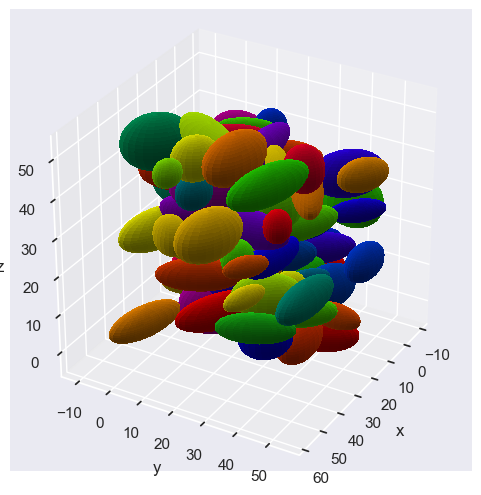

In [5]:
ms.pack()
# **Alternative:** read particles from dump file, instead of executing ms.pack()
# Requires prior exection with particle save option activated: "ms.pack(save_files=True)"
# Import with: "ms.import_particles('dump_files/particle.699.dump')"
ms.plot_ellipsoids()

**Step 4:** After the generation of the particle distribution of the desired volume fraction and fulfilling the experimentally found statistical distribution of particles, the method `voxelize()` generates a voxelated structure in form of a regular 3D mesh of the simulation box. Each voxel lying inside a particle will be assigned to this phase. The remaining voxels will be assigned to the grains according to a growth and distribution algorithm.  
In the figure created by the `plot_voxels()` method, the individual grains are represented in arbitrary colors. With the optional argument "sliced" either the full RVE can be plotted (default) or one octand can be removed from the plot (sliced=True) to get an view into th einternal of the RVE.

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 51034794.05it/s]
INFO:root:Number of grains per phase changed from [90] to [np.int64(89)] during voxelization.


Completed RVE voxelization



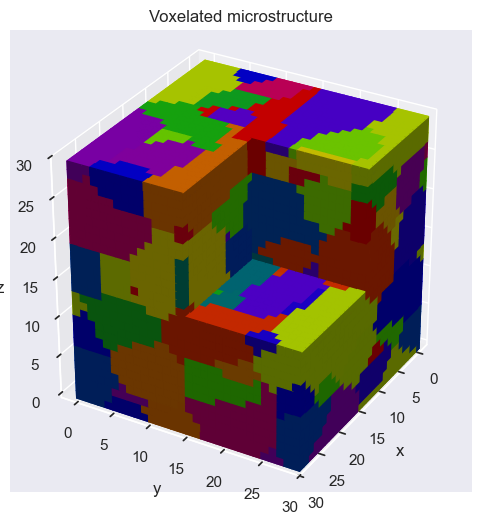

In [6]:
# Create voxel structure and assign each voxel to a grain according to ellipsoids
# at this point, the mesh can be re-defined with the optional argument "dim", e.g. "ms.voxelize(dim=(20,20,20))"
ms.voxelize()
ms.plot_voxels(sliced=True)

**Step 5:** The grain geometry in the voxelized 3D microstructure (representative volume element, RVE) will be analysed statistically with respect to the grain size distribution and the aspect ratio distribution. This is accomplished by constructing the smallest cuboid containing all its voxels to each grain and analyzing the statistical parameters of the distribution of semi-axes of all cuboids. Form these statistical data of the semi-axes, descriptors of the 3D microstructure with respect to grain size and aspect ratio distributions are gathered. The results are plotted with the `plot_stats_init(show_res=True)` method, which compares the resulting grain microstructure statistics of the voxelized RVE with that of the original descriptors.  
In this example, also the microstructural data contained gathered from the ebsd object is passed to the `plot_stats_init()` method together with the fit parameters describing the statistics of that data, such that both information items can be plotted together with the grain statistics of the RVE.  
Note that the choice of the cutoffs has a big influence on the grain geometry in the RVE such that these parameters can be used to match both, input and output statistics, in the best possible way. For practical purposes, however, the distribution of grain sizes (equivalent diameters) in an RVE needs to be more narrow than the ones typically found in experiment. Too small grains will require too many voxels in the RVE, while very large grains imply that the size of the RVE needs to be large enough to fit them. Hence, a compromize has to be found, to create an RVE that can be handled in the numerical simulations for property predictions. Similar restrictions also apply to the aspect ratios of the grains.

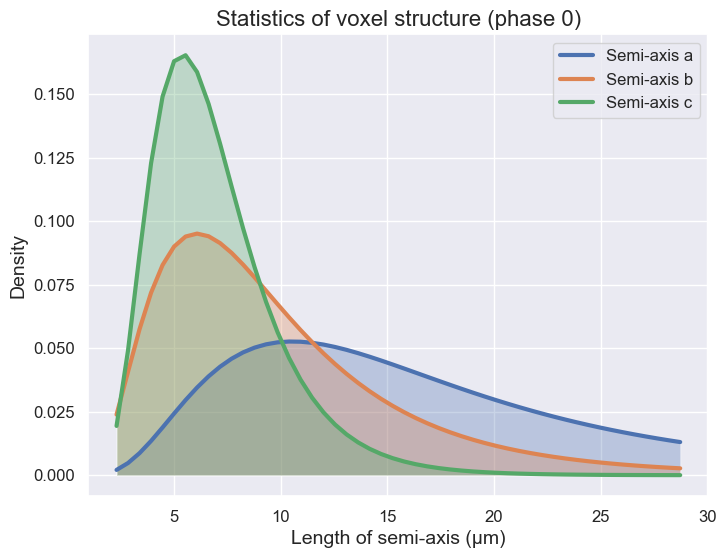


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Input	|  -      	|  -      	|  -      	|   -      	|     -   	|  2.754	|  0.5506	|     18.146 	|  0.7871
Output	|  15.115	|  8.522	|  6.373	|  0.5318	|     0   	|  2.030	|  0.5061	|     18.578 	|  0.4809


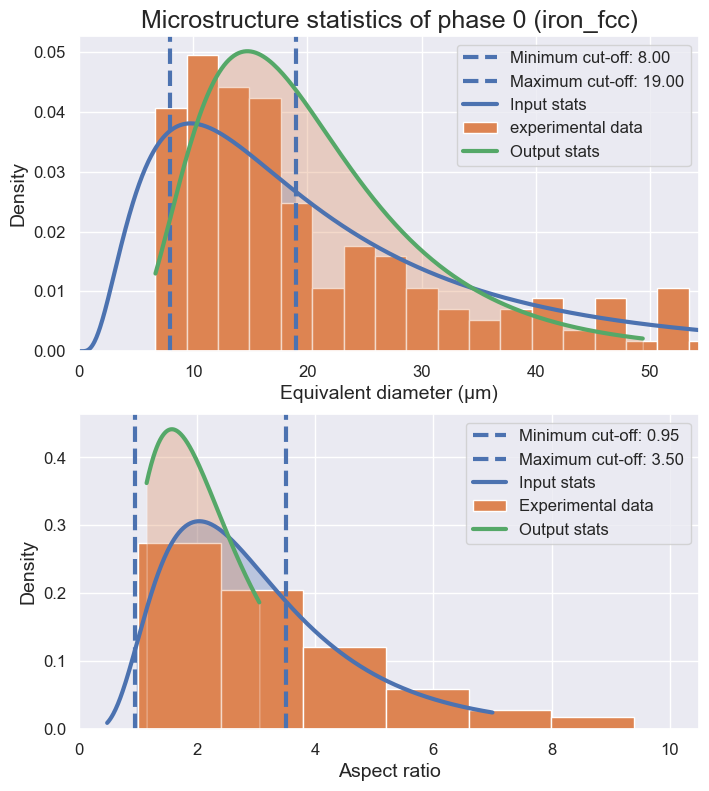

In [7]:
ms.plot_stats_init(show_res=True, gs_data=ms_data['gs_data'], ar_data=ms_data['ar_data'])


## 4. Generate grain orientations and export Abaqus input files
In this step, the texture module of Kanapy is invoked to assign a crystallographic orientation to each grain. The grain orientations are generated in form of Euler angles with the method `ms.generate_orientations()`, which is based on the Matlab package [MTEX](https://mtex-toolbox.github.io).
The grain orientations are generated to follow the orientation distribution function (ODF) of the EBSD map, contained in the ebsd object given as argument. After the orientations for each grain have been generated, the grain structure can be plotted in colors of the IPF key, mimicking an EBSD map.  
The geometrical information of the RVE is exported as Abaqus input file with the ending "_geom.inp" by the method `write_abq()`. This input deck defines a finite element for each voxel. Furthermore, for each grain a set of elements is defined and assigned to a user defined material with the name "GRAIN{grain_id}_MAT". By the same method, the information on the grain orientations is exported as Abaqus input file with the ending "_mat.inp". This file contains the information on the material number to be used in the ICAMS Crystal Plasticity UMAT and the Euler angles for each grain, identified by the name "GRAIN{grain_id}_MAT". The _geom.inp file contains an *INCLUDE command to read the material definitions in the _mat.inp file.

INFO:root:Using ORIX library to read EBSD maps and generate orientations.


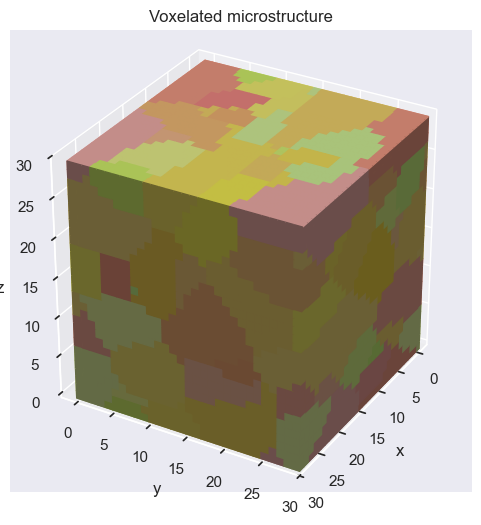


Writing RVE as ABAQUS file "./from_ebsd_vox30_gr89_pbc_geom.inp"
Using brick element type C3D8.
---->DONE! 



'./from_ebsd_vox30_gr89_pbc_geom.inp'

In [8]:
ms.generate_orientations(ebsd)  # downsample ODF of EBSD map to actual number of grains
ms.plot_voxels(ori=True)  # plot voxelized grains in color code of IPF key

# write Abaqus input deck {name}_geom.inp for voxelated structure
# file {name}_mat.inp contains material definitions for ICAMS CP-UMAT together with Euler angles
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'from_ebsd_vox{Nv}_gr{ms.Ngr}_{ptag}'
fname = ms.write_abq(nodes='v', file=ftrunc+'_geom.inp', ialloy=4) # parameter "ialloy" refers to material number of austenite in ICAMS CP-UMAT


**Note 1:** To generate a valid Abaqus model the {}_geom.inp file can be imported directly into Abaqus CAE or included into a generic Abaqus deck (.inp file) via "*INCLUDE" commands. After that, the load step and boundary conditions must be specified.

**Note 2:** An Abaqus model with periodic boundary conditions can be generated by executing the Python script "Create_PeriodicBC_EDGE_3D.py" in the form  
`python Create_PeriodicBC_EDGE_3D.py {file_trunc}_geom.inp`  
This generates a subfolder-structure with different files. The resulting periodic geometry can by included into an Abaqus deck via the command "*Include, input=PeriodicData/geometry_Periodic.inp". An example for such an input deck for a periodic structure is avalaible in the file "Fatigue_BC_Amp_05.inp".


## 5. Safe voxelized structure
With the method `write_voxels()` the information about geometry of the voxel structure and the grain orientations are written into a JSON file, which can be re-imported into Kanapy to safe the packing and voxelization steps, as demonstrated below.


In [9]:
# Save Kanapy microstructure as voxel file
ms.write_voxels(file=f'{matname}_voxels.json', script_name='ebsd2rve.ipynb', mesh=False, system=False)

Writing voxel information of microstructure to ./iron_fcc_voxels.json.


### 5.1 Import voxel file

JSON files with voxel structures can be imported instead of RVE generation and processed further. Note that also grain orientations are stored in the JSON file and can be recaptured. As no initial statistical descriptors are know in this case, the `plot_stats()` method is used in this case.

Creating an RVE from voxel input
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (50, 50, 50) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.6667 1.6667 1.6667](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: iron_fcc (100.0%)


    Generating voxels inside RVE

 Voxel structure imported.



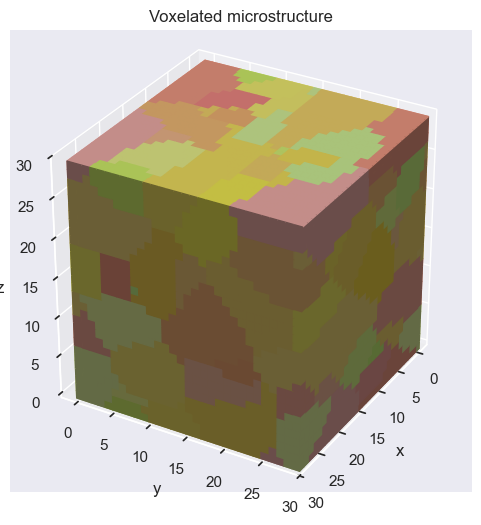

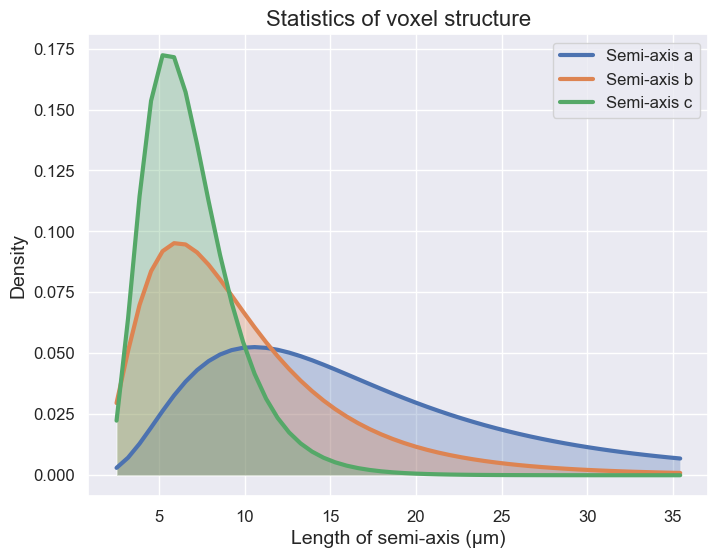


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Voxels	|  15.115	|  8.522	|  6.373	|  0.5235	|     0   	|  2.030	|  0.4950	|     18.578 	|  0.4809


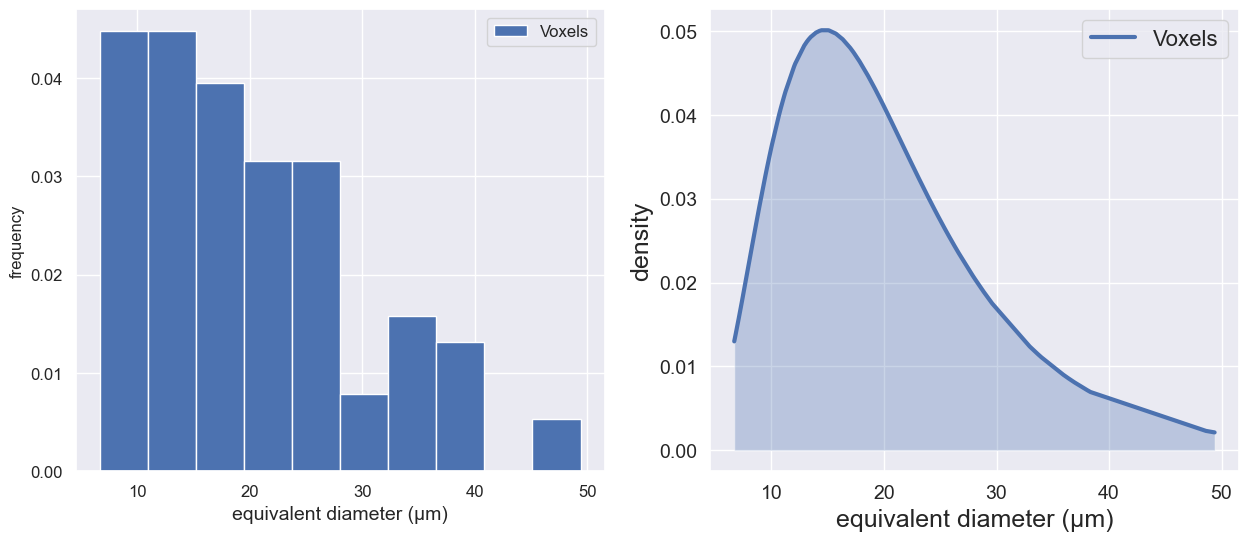

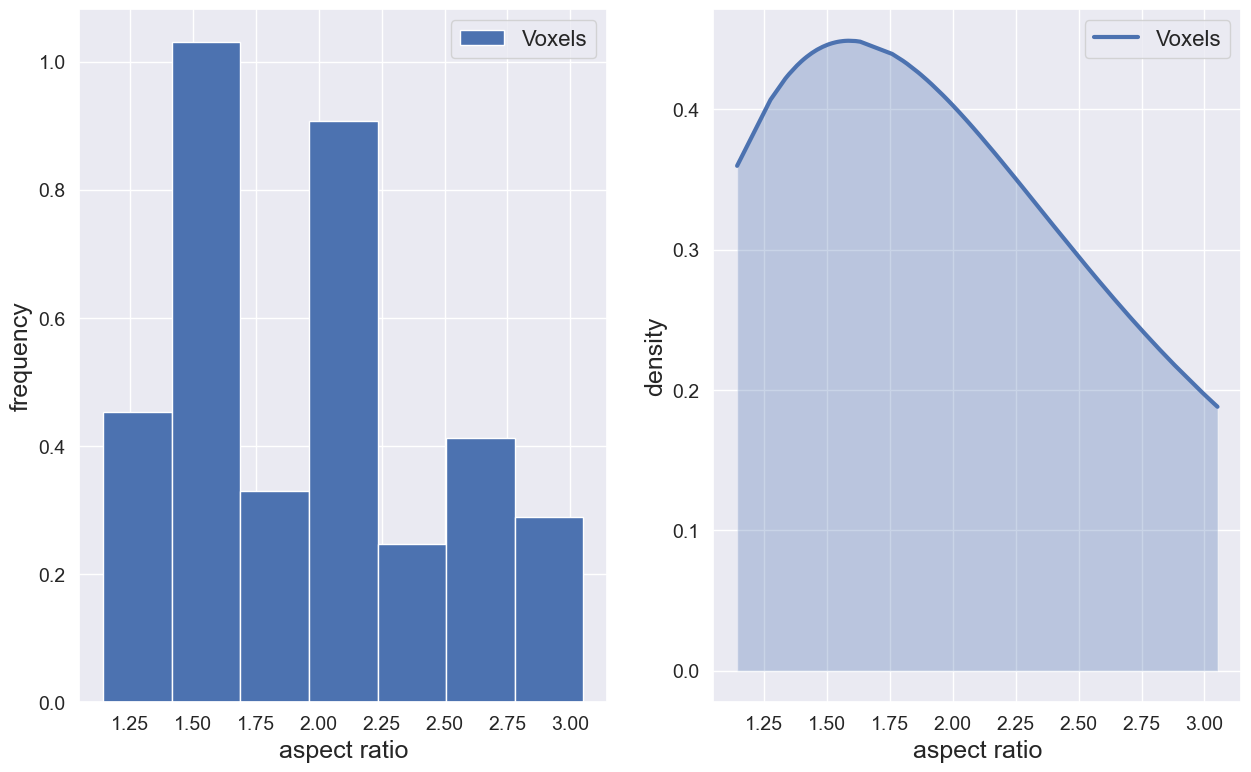

In [10]:
ms2 = knpy.import_voxels(f'{matname}_voxels.json')
ms2.plot_voxels(ori=True)
ms2.plot_stats(show_all=True)